### Results of PES inference of H2 molecule by optimizing only $U(g(b),\{\Theta\})$

#### <u>Code to reproduce the result in Fig. 11</u>

- 4 qubits system for H2 molecule
- Replace the PQC layer F with a simple function g

In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Set calculation conditions (Do not change)

In [2]:
# Do not change the following parameters

num_qubits = 4 # number of qubits, n_qubits
reps_pqc = 4   # Depth of PQC, D
reps = 1       # number of block PQC layer of HQCNN

### Make Datasets

In [3]:
def make_testdata(r_min, r_max, data_num):
    
    X_test = np.linspace(r_min, r_max, data_num)

    return X_test

In [4]:
X_min = 0.45
X_max = 3.0
num_test_data = 30

X_test = make_testdata(X_min, X_max, num_test_data)

### Number of train data

In [5]:
alpha=11

### Define surrogate circuit model

In [6]:
from sub.pqc import QNNcircuit_PNC_with_g, QNNcircuit_PNC_with_h
from sub.utils import get_qubit_hamiltonian_of_H2
from sub.utils import expval

In [7]:
# PES inference using our proposed quantum surrogate circuit (QSC)
def infer_energy_PNC_with_g(opt_params, X_test):
    global reps_pqc, reps

    energy = []
    for i in tqdm(range(len(X_test))):
        qc0 = QNNcircuit_PNC_with_g(num_qubits, X_test[i], reps_pqc, reps, opt_params)
        hamil = get_qubit_hamiltonian_of_H2(X_test[i])[0]
        energy.append(expval(hamil, qc0))
        
    return energy

In [8]:
# PES inference using the previous Xia's model (HQCNN)
def infer_energy_PNC_with_h(opt_params, X_test):
    global reps_pqc, reps

    energy = []
    for i in tqdm(range(len(X_test))):
        qc0 = QNNcircuit_PNC_with_h(num_qubits, X_test[i], reps_pqc, reps, opt_params, weight=np.pi)
        hamil = get_qubit_hamiltonian_of_H2(X_test[i])[0]
        energy.append(expval(hamil, qc0))
        
    return energy

In [9]:
#load preoptimized parameters
filename1 = './params/H2_QSC_alpha_11_with_g.pickle'  
filename2 = './params/H2_QSC_alpha_11_with_h.pickle'  

with open(filename1, 'rb') as f1:
    opt_params1 = pickle.load(f1)
with open(filename2, 'rb') as f2:
    opt_params2 = pickle.load(f2)
    
f1.close()
f2.close()

In [10]:
print(len(opt_params1))
print(opt_params1)

11
[ 0.85166827 -0.50438406  0.58747659  0.05829349  0.67003488  0.1014114
 -0.05899917  0.87990945  1.10106565  0.49175097  0.69080405]


In [11]:
print(len(opt_params2))
print(opt_params2)

11
[ 0.95395624  1.60552233  0.32890851  0.88096637  1.46904812  0.00197691
  0.20762482 -0.248773    0.71199625  1.24239613  1.13454176]


/home/nishida/software/anaconda3/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


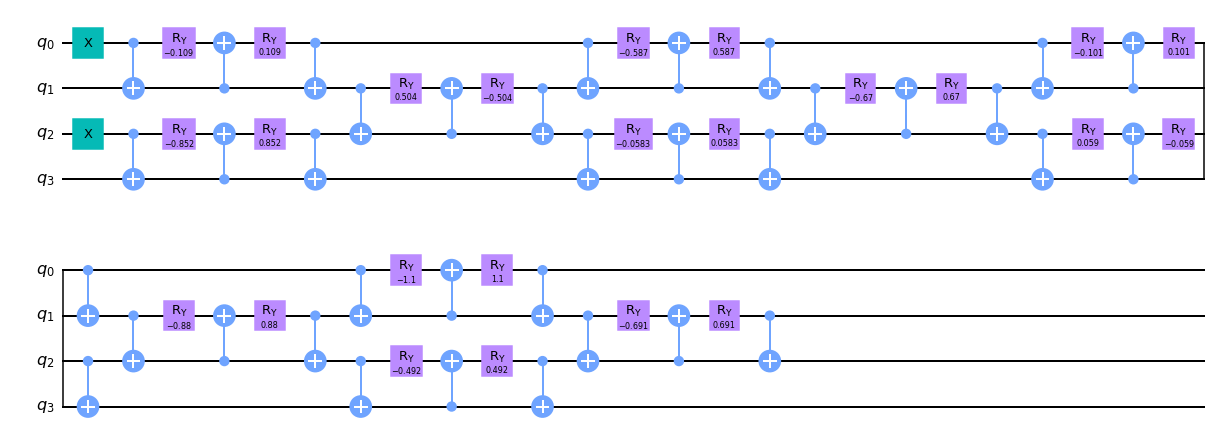

In [12]:
# example of QSC
qc = QNNcircuit_PNC_with_g(num_qubits, X_test[0], reps_pqc, reps, opt_params1)
qc.draw('mpl')

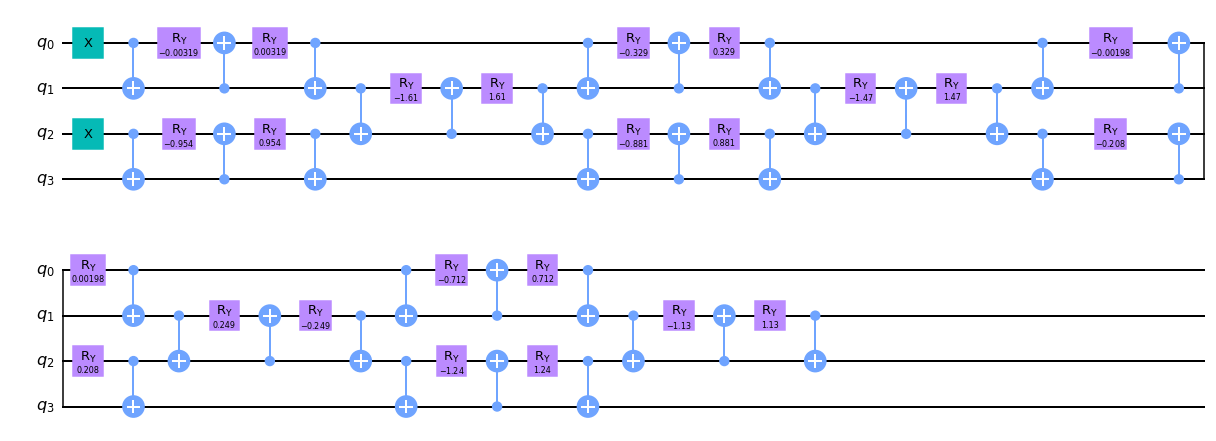

In [13]:
# example of QSC
qc = QNNcircuit_PNC_with_h(num_qubits, X_test[0], reps_pqc, reps, opt_params2, weight=np.pi)
qc.draw('mpl')

### PES inference

In [14]:
# energy inference
eng1 = infer_energy_PNC_with_g(opt_params1, X_test)
eng2 = infer_energy_PNC_with_h(opt_params2, X_test)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:46<00:00,  1.55s/it]


In [15]:
# exact solution
with open('./classical_sol/exact_h2_e0.45-3.0.pickle','rb') as g:
    exact_energy = pickle.load(g)

### Plot results

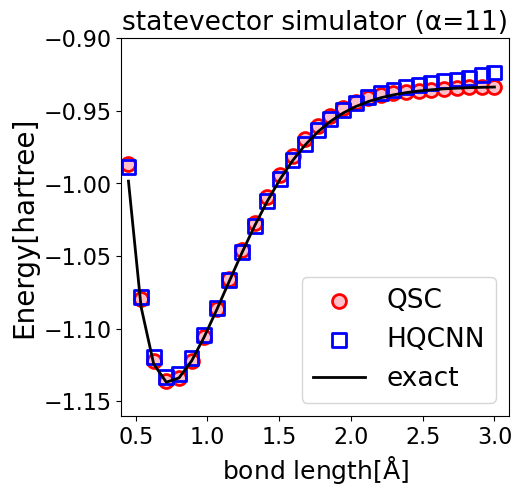

In [16]:
plt.figure(figsize=(5, 5), dpi=100)

x = []
for i in range(len(X_test)):
    x.append(X_test[i])


plt.scatter(x,eng1,marker='o',s=100, facecolor='pink', edgecolors='red',lw=2,label='QSC')
plt.scatter(x,eng2,marker='s',s=100, facecolor='None', edgecolors='blue',lw=2,label='HQCNN')
plt.plot(exact_energy[0],exact_energy[1], c='black',label='exact',lw=2)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=19)

plt.title('statevector simulator (α=%s)'%alpha,fontsize=19)

plt.xlabel(
    'bond length[$\mathrm{\AA}$]',
    fontsize=18,
)
plt.ylabel('Energy[hartree]', fontsize=20)

plt.xlim(0.4,3.1)
plt.ylim(-1.16,-0.9)

plt.show()

In [17]:
deltaE1= []
deltaE2= []

for i in range(len(x)):
    deltaE1.append(np.abs(np.array(eng1)[i][0]-np.array(exact_energy[1])[i]))
    deltaE2.append(np.abs(np.array(eng2)[i][0]-np.array(exact_energy[1])[i]))

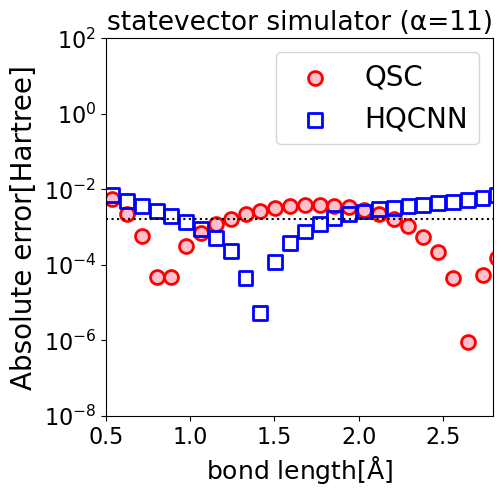

In [18]:
plt.figure(figsize=(5, 5), dpi=100)

#plt.scatter(x,deltaE1,marker='o',s=50,facecolor='None', edgecolors='red',lw=2,label='QSC')
plt.scatter(x,deltaE1,marker='o',s=100,facecolor='pink', edgecolors='red',lw=2,label='QSC')
plt.scatter(x,deltaE2,marker='s',s=100,facecolor='None', edgecolors='blue',lw=2,label='HQCNN')
plt.hlines(0.00159,0.5, 3.0,  color='black', linestyles='dotted')

plt.xlim(0.5,2.8)
plt.ylim(1E-8,100)
plt.yscale('log')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=20)
plt.xlabel('bond length[$\mathrm{\AA}$]', fontsize=18)
plt.ylabel('Absolute error[Hartree]', fontsize=20)

plt.title('statevector simulator (α=%s)'%alpha,fontsize=19)

plt.show()

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table